In [1]:
import os

from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from denovo_utils.analysis.metrics import load_seq_score_dicts
from denovo_utils.analysis.metrics import get_match_score_table, get_prc_curve

from psm_utils import Peptidoform
from tqdm import tqdm
from peak_pack.utils import calculate_ppm

from denovo_utils.io.read import load_psmlist

from Levenshtein import editops # To track actions for transpositions
from nltk import edit_distance # For Damerau–Levenshtein distance

2025-03-27 10:47:03.619106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-27 10:47:03.771013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-27 10:47:03.813353: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modification already exists in ModificationsDB. Skipping.


# Goal of the notebook

Error locations:
- N-terminal or C-terminal? 
- In parts where there is no ion evidence ?

Error types:

- Is there a pattern on what the errors actually are? 
- Are specific amino acids always confused ? 
- Are some amino acids always swapped ? 
- What about the modifications ?

In [2]:
mapper = {
    "[+25.980265]-": "b",
    "[Formula:H-2C1O1]-": 'b',
    "[UNIMOD:1]-": "a",
    "[UNIMOD:5]-": "d",
    "[UNIMOD:385]-": "e",
    "Q[UNIMOD:7]": "q",
    "N[UNIMOD:7]": "n",
    "C[UNIMOD:4]": "c",
    "M[UNIMOD:35]": 'm',
    "S[UNIMOD:21]": 's',
    "T[UNIMOD:21]": 't',
    "Y[UNIMOD:21]": 'y',
    "L": "I"
}

mapper_reverse = {
    v: k for k, v in mapper.items()
}
_ = mapper_reverse.pop('I')

def peptidoform_to_lstring(peptidoform, mapper):
    if isinstance(peptidoform, Peptidoform):
        new_peptidoform = peptidoform.proforma
    else:
        new_peptidoform = peptidoform
    for p, l in mapper.items():
        new_peptidoform = new_peptidoform.replace(p, l)
    return new_peptidoform.split('/')[0]

# 1. Load the data

This dataset with all results, contains 1.390.735 PSMs

In [ ]:
root_results_dn = '/public/compomics3/Sam/PXD028735/QExactive/rescoring'
root_mgf = '/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
root_results_db = '/public/compomics3/Sam/PXD028735/QExactive/search_results/identification'
run_names = [
    'LFQ_Orbitrap_DDA_Ecoli_01',
    'LFQ_Orbitrap_DDA_Human_01',
    'LFQ_Orbitrap_DDA_QC_01',
    'LFQ_Orbitrap_DDA_Yeast_01'
]

engine_names = [
    'adanovo',
    'pihelixnovo',
    'piprimenovo',
    'casanovo',
    'instanovo',
    'contranovo',
    'novob',
    'pepnet',
]

denovo_order = [
    'pi-PrimeNovo',
    'pi-HelixNovo',
    'AdaNovo',
    'instanovo',
    'novob',
    'casanovo',
    'contranovo',
    'pepnet'
]

runs = {}
for run_name in run_names:
    print(f"Run: {run_name}")
    run = Run(run_name)

    mgf_path = os.path.join(root_mgf, run_name + '.mgf')

    # Load a ground-truth
    psmlist_gt = load_psmlist(os.path.join(
        root_results_dn, run_name, 'psmlist', 'ground_truth.parquet'
    ))
    # parser = DenovoEngineConverter.select('sage')
    # psmlist_gt = parser.parse(
    #     result_path=os.path.join(root_results_db, run_name + '.sage.tsv'),
    #     mgf_path=mgf_path
    # )
    run.load_data(
        psmlist=psmlist_gt.get_rank1_psms(),
        score_names=[],
        is_ground_truth=True
    )

    # Load the de novo results
    for engine_name in engine_names:
        print(f'loading {engine_name}')
        dn_path = os.path.join(root_results_dn, run_name, 'psmlist', engine_name + '.parquet')
        
        psmlist_denovo = load_psmlist(psm_path=dn_path)
        
        # parser = DenovoEngineConverter.select(engine_name)
        # psmlist_denovo = parser.parse(
        #     result_path=os.path.join(root_results_dn, engine_name, run_name + f'.{engine_name}.some_extension'),
        #     mgf_path=mgf_path
        # )
        run.load_data(
            psmlist=psmlist_denovo,
            score_names=[],
            is_ground_truth=False
        )
    
    runs[run_name] = run

Run: LFQ_Orbitrap_DDA_Ecoli_01


100%|██████████| 24285/24285 [00:00<00:00, 33382.28it/s]


loading adanovo


100%|██████████| 61843/61843 [00:00<00:00, 135524.43it/s]


loading pihelixnovo


100%|██████████| 61955/61955 [00:00<00:00, 144445.62it/s]


loading piprimenovo


100%|██████████| 58682/58682 [00:00<00:00, 142062.04it/s]


loading casanovo


100%|██████████| 61876/61876 [00:00<00:00, 137848.98it/s]


loading instanovo


100%|██████████| 61562/61562 [00:00<00:00, 146163.21it/s]


loading contranovo


100%|██████████| 30999/30999 [00:00<00:00, 122927.89it/s]


loading novob


100%|██████████| 61479/61479 [00:00<00:00, 140428.23it/s]


loading pepnet


100%|██████████| 62560/62560 [00:02<00:00, 21907.45it/s] 


Run: LFQ_Orbitrap_DDA_Human_01


100%|██████████| 90817/90817 [00:06<00:00, 14552.38it/s]


loading adanovo


100%|██████████| 115178/115178 [00:01<00:00, 64972.05it/s]


loading pihelixnovo


100%|██████████| 115417/115417 [00:07<00:00, 14577.34it/s]


loading piprimenovo


100%|██████████| 111287/111287 [00:01<00:00, 66617.54it/s]


loading casanovo


100%|██████████| 115362/115362 [00:01<00:00, 61574.74it/s]


loading instanovo


100%|██████████| 114725/114725 [00:01<00:00, 66070.11it/s]


loading contranovo


100%|██████████| 57640/57640 [00:00<00:00, 59749.71it/s]


loading novob


100%|██████████| 114064/114064 [00:01<00:00, 65855.58it/s]


loading pepnet


100%|██████████| 118245/118245 [00:01<00:00, 70538.51it/s]


Run: LFQ_Orbitrap_DDA_QC_01


100%|██████████| 83941/83941 [00:01<00:00, 56426.35it/s]


loading adanovo


100%|██████████| 107088/107088 [00:01<00:00, 68550.59it/s]


loading pihelixnovo


100%|██████████| 107182/107182 [00:01<00:00, 63073.65it/s]


loading piprimenovo


100%|██████████| 103511/103511 [00:01<00:00, 63724.82it/s]


loading casanovo


100%|██████████| 107203/107203 [00:01<00:00, 64217.74it/s]


loading instanovo


100%|██████████| 106604/106604 [00:01<00:00, 69388.05it/s]


loading contranovo


100%|██████████| 53533/53533 [00:00<00:00, 58830.52it/s]


loading novob


100%|██████████| 106075/106075 [00:01<00:00, 69763.84it/s]


loading pepnet


100%|██████████| 109340/109340 [00:01<00:00, 70223.87it/s]


Run: LFQ_Orbitrap_DDA_Yeast_01


100%|██████████| 67111/67111 [00:01<00:00, 62394.29it/s]


loading adanovo


100%|██████████| 102427/102427 [00:01<00:00, 87009.35it/s]


loading pihelixnovo


100%|██████████| 102483/102483 [00:01<00:00, 85797.19it/s]


loading piprimenovo


100%|██████████| 96975/96975 [00:01<00:00, 85618.83it/s] 


loading casanovo


100%|██████████| 102518/102518 [00:01<00:00, 83890.55it/s]


loading instanovo


100%|██████████| 101883/101883 [00:01<00:00, 88970.39it/s]


loading contranovo


100%|██████████| 51215/51215 [00:00<00:00, 81403.34it/s]


loading novob


100%|██████████| 101183/101183 [00:01<00:00, 88255.83it/s]


loading pepnet


100%|██████████| 103785/103785 [00:01<00:00, 97852.67it/s]


Evaluate

In [4]:
for run in runs.values():
    for spectrum in tqdm(run.spectra.values()):
        spectrum.compare_gt(
            'score_ms2rescore',
            ignore_score=True
        )

100%|██████████| 43131/43131 [00:29<00:00, 1472.33it/s]


In [5]:
spectrum

Spectrum ID: controllerType=0 controllerNumber=1 scan=66857
Ground-truth: IPILLR/2 ({'peptide': {'sage': 0.9793421626091003}, 'aa': {}})
Candidates:
	LPLLLR/2 ({'peptide': {'AdaNovo': 0.9934163093566895}, 'aa': {'AdaNovo': (0.98917, 0.99452, 0.99264, 0.98761, 0.99656, 0.9967)}})
	LPLLLR/2 ({'peptide': {'pi-HelixNovo': 0.9800000190734863}, 'aa': {}})
	LPLLLR/2 ({'peptide': {'pi-PrimeNovo': 0.9426490068435669}, 'aa': {}})
	LPLLLR/2 ({'peptide': {'casanovo': 0.9864637851715088}, 'aa': {'casanovo': (0.98492, 0.98833, 0.98905, 0.98919, 0.98906, 0.97648)}})
	LPLLLR/2 ({'peptide': {'instanovo': -0.02716885879635811}, 'aa': {}})
	LPLLLR/2 ({'peptide': {'novob': 0.9971590042114258}, 'aa': {}})
	LPLLLR/2 ({'peptide': {'pepnet': 0.9452999830245972}, 'aa': {'pepnet': [0.9999571, 0.9924597, 0.9558322, 0.99767417, 0.99956423, 0.99945015]}})

# 3. Calculate (Damerau)-levenshtein distance

In [6]:
for run_name, run in runs.items():
    for spectrum in tqdm(run.spectra.values()):
        peptidoform_gt = peptidoform_to_lstring(spectrum.psm_gt.peptidoform, mapper=mapper)
        for psm_candidate in spectrum.psm_candidates:
            peptidoform_candidate = peptidoform_to_lstring(psm_candidate.peptidoform, mapper=mapper)

            changes = editops(
                peptidoform_candidate,
                peptidoform_gt
            )
            damerau_L = edit_distance(
                s1=peptidoform_candidate,
                s2=peptidoform_gt,
                transpositions=True
            )
            
            psm_candidate.scores.add_score(
                score=len(changes),
                metadata='levenshtein',
                score_type='peptide',
                overwrite=True
            )
            psm_candidate.scores.add_score(
                score=damerau_L,
                metadata='damerau-levenshtein',
                score_type='peptide',
                overwrite=True
            )
            psm_candidate.swaps = changes

  0%|          | 0/15982 [00:00<?, ?it/s]

100%|██████████| 43131/43131 [00:36<00:00, 1176.99it/s]


### 3.1 Overview of the levenshtein distances per tool

Make distinction between two amino acid errors and an error due to switching around two amino acid.

This can be defined with the Damerau variant.

In [7]:
import pandas as pd

levenshtein_df = []

for run in runs.values():
    for spectrum in run.spectra.values():
        for psm in spectrum.psm_candidates:
            entry = {
                'tool': psm.engine_name,
                'levenshtein': psm.scores.get_score('levenshtein'),
                'damerau-levenshtein': psm.scores.get_score('damerau-levenshtein'),
                'swaps': psm.swaps,
                'peptide_evidence_dn': psm.peptide_evidence,
                'peptide_evidence_gt': spectrum.psm_gt.peptide_evidence,
                'spectrum_id': spectrum.spectrum_id,
                'run': run.run_id
            }
            levenshtein_df.append(entry)

levenshtein_df = pd.DataFrame(levenshtein_df)

In [8]:
levenshtein_df['L-normalized'] = levenshtein_df.apply(
    lambda x: x['levenshtein'] / max(
        len(peptidoform_to_lstring(x['peptide_evidence_gt'].peptidoform, mapper=mapper)),
        len(peptidoform_to_lstring(x['peptide_evidence_dn'].peptidoform, mapper=mapper)),
    ), axis=1
)

levenshtein_df['DL-normalized'] = levenshtein_df.apply(
    lambda x: x['damerau-levenshtein'] / max(
        len(peptidoform_to_lstring(x['peptide_evidence_gt'].peptidoform, mapper=mapper)),
        len(peptidoform_to_lstring(x['peptide_evidence_dn'].peptidoform, mapper=mapper)),
    ), axis=1
)

<Axes: xlabel='L-normalized', ylabel='Count'>

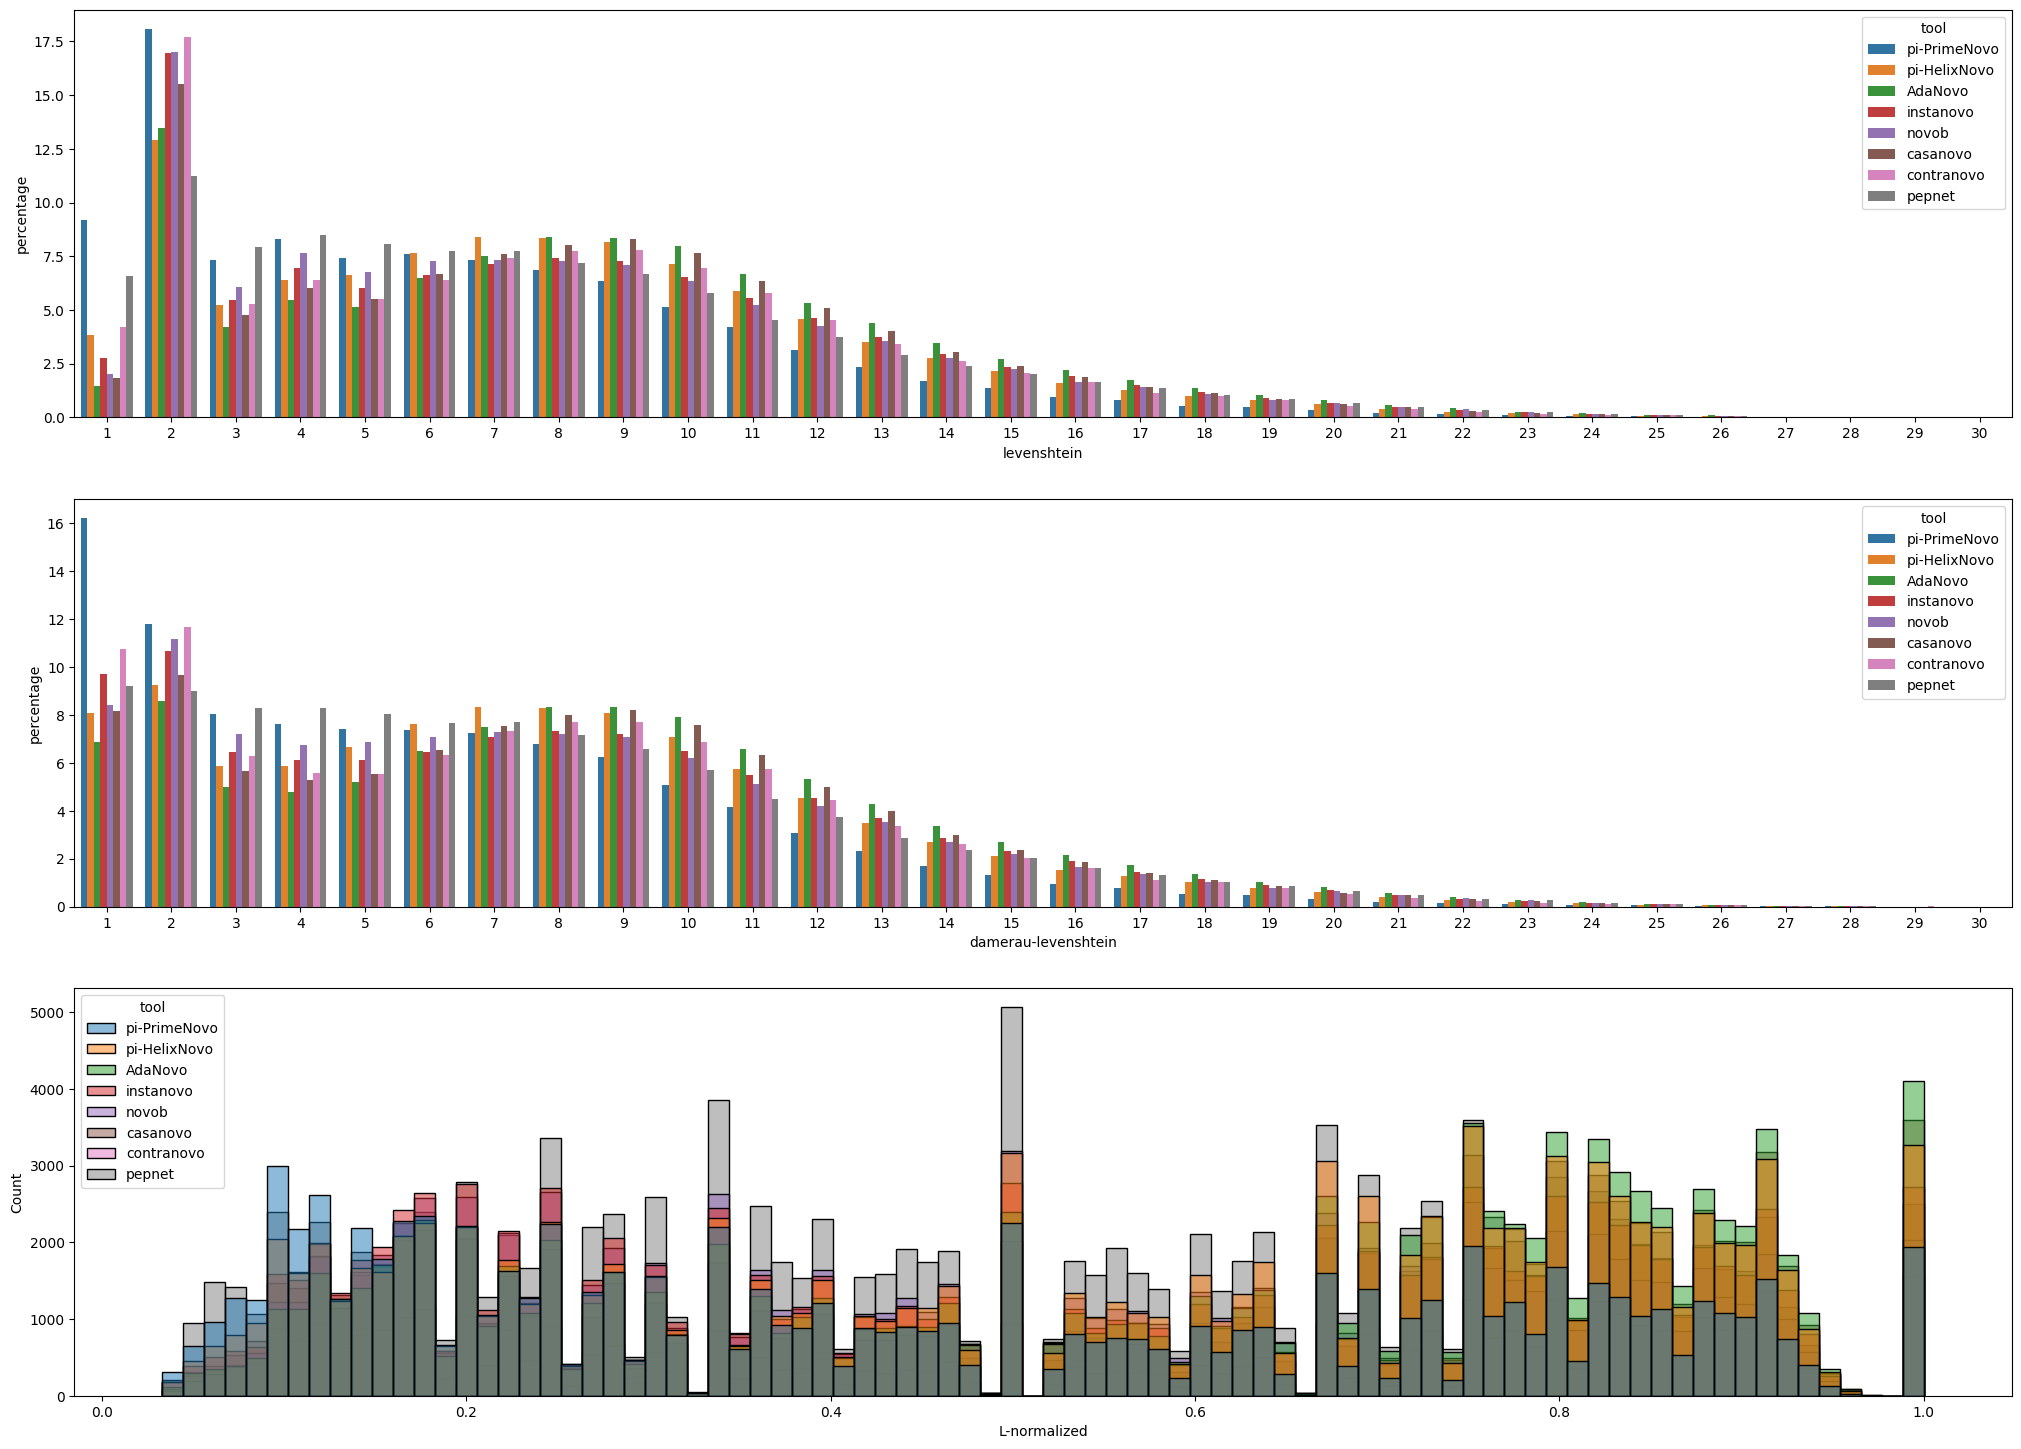

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(25,18))

normalized_df = (
    levenshtein_df[levenshtein_df['levenshtein'] > 0]
    .groupby(['tool', 'levenshtein'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

sns.barplot(
    normalized_df,
    x='levenshtein',
    y='percentage',
    hue='tool',
    hue_order=denovo_order,
    ax=ax[0]
)

normalized_df = (
    levenshtein_df[levenshtein_df['damerau-levenshtein'] > 0]
    .groupby(['tool', 'damerau-levenshtein'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

sns.barplot(
    normalized_df,
    y='percentage',
    x='damerau-levenshtein',
    hue='tool',
    hue_order=denovo_order,
    ax=ax[1]
)

sns.histplot(
    levenshtein_df[levenshtein_df['levenshtein']!=0],
    x='L-normalized',
    hue='tool',
    hue_order=denovo_order,
    ax=ax[2]
)

<Axes: xlabel='L-normalized', ylabel='Density'>

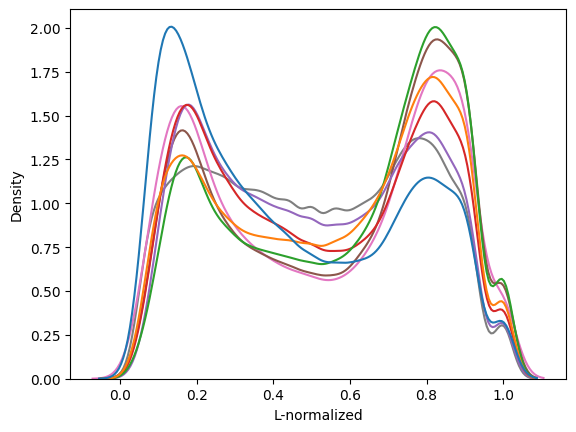

In [573]:
sns.kdeplot(
    levenshtein_df[levenshtein_df['levenshtein']!=0],
    x='L-normalized',
    hue='tool',
    hue_order=denovo_order,
    common_norm=False,
    legend=False
)

<Axes: xlabel='DL-normalized', ylabel='Density'>

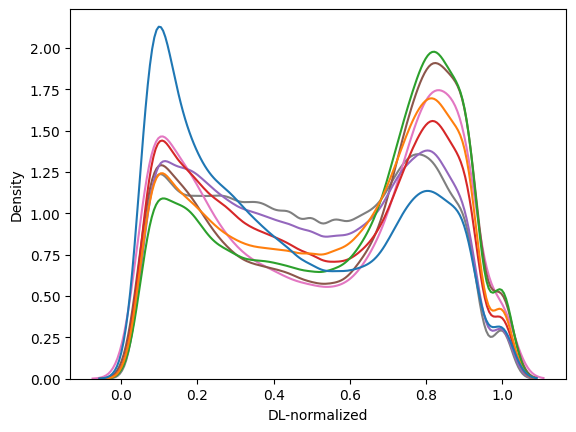

In [575]:
sns.kdeplot(
    levenshtein_df[levenshtein_df['levenshtein']!=0],
    x='DL-normalized',
    hue='tool',
    hue_order=denovo_order,
    common_norm=False,
    legend=False
)

---

Change tracker source code and tests

In [9]:
class ChangeTracker:
    def __init__(self):
        self.change_s1 = ''
        self.change_s2 = ''
        self.collection = []
        self.indices = []
        self.prev_action = None
    

    def collect_change(self):
        '''Collect an entry.'''
        self.collection.append(
            {
                's1': self.change_s1,
                's2': self.change_s2,
                'indices': self.indices
            }
        )
        self.flush()
    
    def flush(self):
        '''Clear the tracker.'''
        self.change_s1 = ''
        self.change_s2 = ''
        self.indices = []
        self.prev_action = None

    def track_changes(self, s1, s2, actions):
        self.collection = []

        deleted = 0
        prev_index = 0
        flag_start = True

        for (action, idx_s1, idx_s2) in actions:

            # New site of change
            if action == 'delete':
                deleted += 1
            idx_s2_deletion = idx_s2 - deleted

            if idx_s2_deletion - prev_index > 1 and not flag_start:
                # If multiple deletes after each other
                if len(self.indices)>0 and (self.indices[-1]==idx_s2):
                    pass
                else:
                    self.collect_change()

            if action == 'insert':
                # change_s1 += s1[idx_s1]
                self.change_s2 += s2[idx_s2]         

            elif action == 'replace':
                # Fixes weird bug where it does not detect new site
                if self.prev_action == 'delete':
                    self.collect_change()

                self.change_s1 += s1[idx_s1]
                self.change_s2 += s2[idx_s2]
            elif action == 'delete':
                # Transposition
                if self.prev_action == 'insert':
                    self.change_s1 += s1[idx_s1-1]
                    self.change_s2 += s2[idx_s2_deletion]
                    self.change_s1 += s1[idx_s1]
                
                elif self.prev_action == 'replace':
                    self.change_s1 += s1[idx_s1]

                elif self.prev_action == 'delete' and not (self.indices[-1]==idx_s2):
                    self.collect_change()
                    self.change_s1 += s1[idx_s1]

                else:
                    self.change_s1 += s1[idx_s1]
                # change_s2 += s2[idx_s2-deleted]
            
            if action == 'delete' and self.prev_action == 'insert':  
                self.indices.append(idx_s2-1)
            else:
                self.indices.append(idx_s2)

            prev_index = idx_s2_deletion
            self.prev_action = action
            flag_start = False

        self.collect_change()
        return self.collection

    def add_locations(self, peptide_evidence):
        # get ambiguous sites
        ambiguous_indices = []
        ambiguous_tags = peptide_evidence.get_ambiguous_tag_idx()
        for idx_1, idx_2 in ambiguous_tags:
            ambiguous_indices += list(range(idx_1, idx_2+1))
        
        for change in self.collection:
            change['ambiguous_site'] = True
            for idx in change['indices']:
                if idx not in ambiguous_indices:
                    change['ambiguous_site'] = False
                    break
            
            change['n_term'] = change['indices'][0]
            change['c_term'] = len(peptide_evidence.peptidoform) - change['indices'][-1] - 1
        
        return self.collection

In [507]:
# 1 transposition
s1_1 = "ACBDEFGHJJ"
s2_1 = "ABCDEFGHIJ"
actions_1 = editops(
    s1_1,
    s2_1
)

# 2 seperate inserts
s1_2 = "ACE"
s2_2 = "ABCDE"
actions_2 = editops(
    s1_2,
    s2_2
)

# 1 insert and a transposition
s1_3 = "ABDEGF"
s2_3 = "ABCDEFG"
actions_3 = editops(
    s1_3,
    s2_3
)

# 1 deletion and an insertion
s1_4 = 'aGTPGDDEEAQR'
s2_4 = 'GFPGDDEEAQR'
actions_4 = editops(
    s1_4,
    s2_4
)

# 1 insertion, 1 deletion, 1 insertion and a transposition
s1_5 = "ACDEFHIJK"
s2_5 = "ABCEFGHIJK"
actions_5 = editops(
    s1_5,
    s2_5
)

# N-terminal deletion, and insertion at 2nd place
s1_6 = "ABCDEFGHIJK"
s2_6 = "BCDEFGIJ"
actions_6 = editops(
    s1_6,
    s2_6
)

# Deletion at site 1
s1_7 = "ABCDEFGHIJK"
s2_7 = "ACDEFGIJ"
actions_7 = editops(
    s1_7,
    s2_7
)

# ALl deletions
# Deletion at site 1
s1_8 = 'aQGLLGGGGGGAGAGRQGLLPVLESLK'
s2_8 = 'HHGPQTLYLPVTLSSIPVFQR'
actions_8 = editops(
    s1_8,
    s2_8
)

s1_9 = 'LPGLYYIETDSTGER'
s2_9 = 'LPGLYYLETDMDRK'
actions_9 = editops(
    s1_9,
    s2_9
)

In [508]:
tracker = ChangeTracker()

for (s1, s2, actions) in [
    (s1_1, s2_1, actions_1),
    (s1_2, s2_2, actions_2),
    (s1_3, s2_3, actions_3),
    (s1_4, s2_4, actions_4),
    (s1_5, s2_5, actions_5),
    (s1_6, s2_6, actions_6),
    (s1_7, s2_7, actions_7),
    (s1_8, s2_8, actions_8),
    (s1_9, s2_9, actions_9)
]:
    print()
    print(s1)
    print(s2)
    print(actions)
    
    res = tracker.track_changes(
        s1=s1,
        s2=s2,
        actions=actions
    )
    print(res)


ACBDEFGHJJ
ABCDEFGHIJ
[('insert', 1, 1), ('delete', 2, 3), ('replace', 8, 8)]
[{'s1': 'CB', 's2': 'BC', 'indices': [1, 2]}, {'s1': 'J', 's2': 'I', 'indices': [8]}]

ACE
ABCDE
[('insert', 1, 1), ('insert', 2, 3)]
[{'s1': '', 's2': 'B', 'indices': [1]}, {'s1': '', 's2': 'D', 'indices': [3]}]

ABDEGF
ABCDEFG
[('insert', 2, 2), ('insert', 4, 5), ('delete', 5, 7)]
[{'s1': '', 's2': 'C', 'indices': [2]}, {'s1': 'GF', 's2': 'FG', 'indices': [5, 6]}]

aGTPGDDEEAQR
GFPGDDEEAQR
[('delete', 0, 0), ('replace', 2, 1)]
[{'s1': 'a', 's2': '', 'indices': [0]}, {'s1': 'T', 's2': 'F', 'indices': [1]}]

ACDEFHIJK
ABCEFGHIJK
[('insert', 1, 1), ('delete', 2, 3), ('insert', 5, 5)]
[{'s1': 'CD', 's2': 'BC', 'indices': [1, 2]}, {'s1': '', 's2': 'G', 'indices': [5]}]

ABCDEFGHIJK
BCDEFGIJ
[('delete', 0, 0), ('delete', 7, 6), ('delete', 10, 8)]
[{'s1': 'A', 's2': '', 'indices': [0]}, {'s1': 'H', 's2': '', 'indices': [6]}, {'s1': 'K', 's2': '', 'indices': [8]}]

ABCDEFGHIJK
ACDEFGIJ
[('delete', 1, 1), ('delete'

---

In [10]:
def row_to_change_track(row, mapper):
    if row['swaps'] == []:
        return None
    tracker = ChangeTracker()
    _ = tracker.track_changes(
        s1=peptidoform_to_lstring(row['peptide_evidence_dn'].peptidoform, mapper=mapper),
        s2=peptidoform_to_lstring(row['peptide_evidence_gt'].peptidoform, mapper=mapper),
        actions=row['swaps']
    )
    return tracker.add_locations(row['peptide_evidence_gt'])

levenshtein_df['replacements'] = levenshtein_df.progress_apply(
    lambda x: row_to_change_track(
        x, mapper
    ), axis=1
)

100%|██████████| 1390735/1390735 [00:36<00:00, 38236.72it/s]


In [510]:
peptidoform_to_lstring(levenshtein_df.loc[1034906, 'peptide_evidence_dn'].peptidoform, mapper=mapper)

'bHSADIAGNSEVIIPVPAFNVINGGSHAGNK'

In [511]:
len('SGDAAIVDMVPGKPMCVESFSDYPPLGR')

28

In [512]:
len('HSADLAGNSEVLLPVPAFNVLNGGSHAGNK')

30

In [14]:
levenshtein_df.sort_values('levenshtein', ascending=False).loc[1034906, ['peptide_evidence_gt', "peptide_evidence_dn", 'swaps']].to_dict()

{'peptide_evidence_gt': <SG>DAAIVDM[UNIMOD:35]VPG<KP>MC[UNIMOD:4]<VES>FSDYP<PLGR>/4,
 'peptide_evidence_dn': <HSADL>A<GNSE>VLLPVPAFNVLNGGSHAGNK/4,
 'swaps': [('delete', 0, 0),
  ('delete', 1, 0),
  ('replace', 3, 1),
  ('replace', 5, 3),
  ('replace', 7, 5),
  ('replace', 8, 6),
  ('replace', 9, 7),
  ('replace', 10, 8),
  ('insert', 12, 10),
  ('replace', 12, 11),
  ('replace', 13, 12),
  ('insert', 15, 14),
  ('insert', 15, 15),
  ('replace', 16, 17),
  ('replace', 17, 18),
  ('replace', 19, 20),
  ('replace', 20, 21),
  ('replace', 21, 22),
  ('replace', 22, 23),
  ('replace', 23, 24),
  ('replace', 24, 25),
  ('delete', 25, 26),
  ('delete', 26, 26),
  ('delete', 27, 26),
  ('replace', 29, 27),
  ('delete', 30, 28)]}

In [11]:
levenshtein_df['transpositions'] = levenshtein_df.apply(lambda x: x['levenshtein']-x['damerau-levenshtein'], axis=1)

# 4. Investigate errors more closely

### 4.1 Most common single amino acid variants

In [61]:
from itertools import chain

# Gather the single amino acid variants
saa = levenshtein_df[
    (levenshtein_df['levenshtein'] == 1)
]

# Parse the replacements and count them
pairs = saa['replacements'].apply(lambda x: [f"{i['s2']} -> {i['s1']}" for i in x])
pairs['tool'] = saa['tool']
pairs = pairs.groupby('tool').apply(lambda x: pd.Series(list(chain(*x))).value_counts())
pairs = pairs.reset_index()

pairs['percentage'] = pairs.groupby('tool')['replacements'].transform(lambda x: x / x.sum())

# Make a selection for plotting (only the 15 most common ones)
most_common_aas = pairs.groupby('level_1').replacements.sum().sort_values(ascending=False)[:10].index.tolist()
selection = pairs[pairs['level_1'].isin(most_common_aas)]

selection['level_1_'] = selection['level_1'].apply(
    lambda x: peptidoform_to_lstring(x, mapper_reverse)
)
SE_selection = [
    'pi-PrimeNovo',
    'casanovo',
    'instanovo',
    'novob'
]
selection = selection[selection['tool'].isin(SE_selection)]

<Axes: xlabel='replacements', ylabel='tool'>

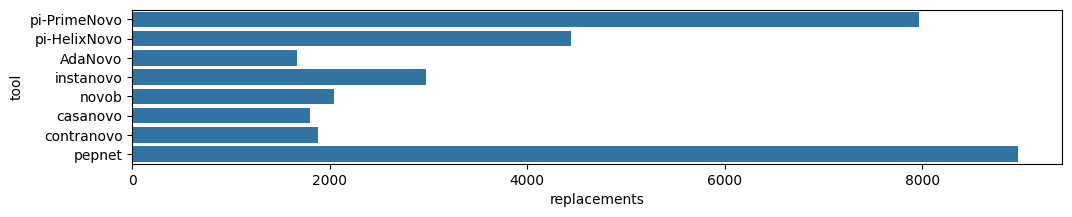

In [17]:
plt.figure(figsize=(12,2))
sns.barplot(
    pairs.groupby('tool').replacements.sum(),
    orient='h',
    order=denovo_order
)

In [52]:
denovo_order

['pi-PrimeNovo',
 'pi-HelixNovo',
 'AdaNovo',
 'instanovo',
 'novob',
 'casanovo',
 'contranovo',
 'pepnet']

Text(0, 0.5, 'Ground-truth -> De Novo')

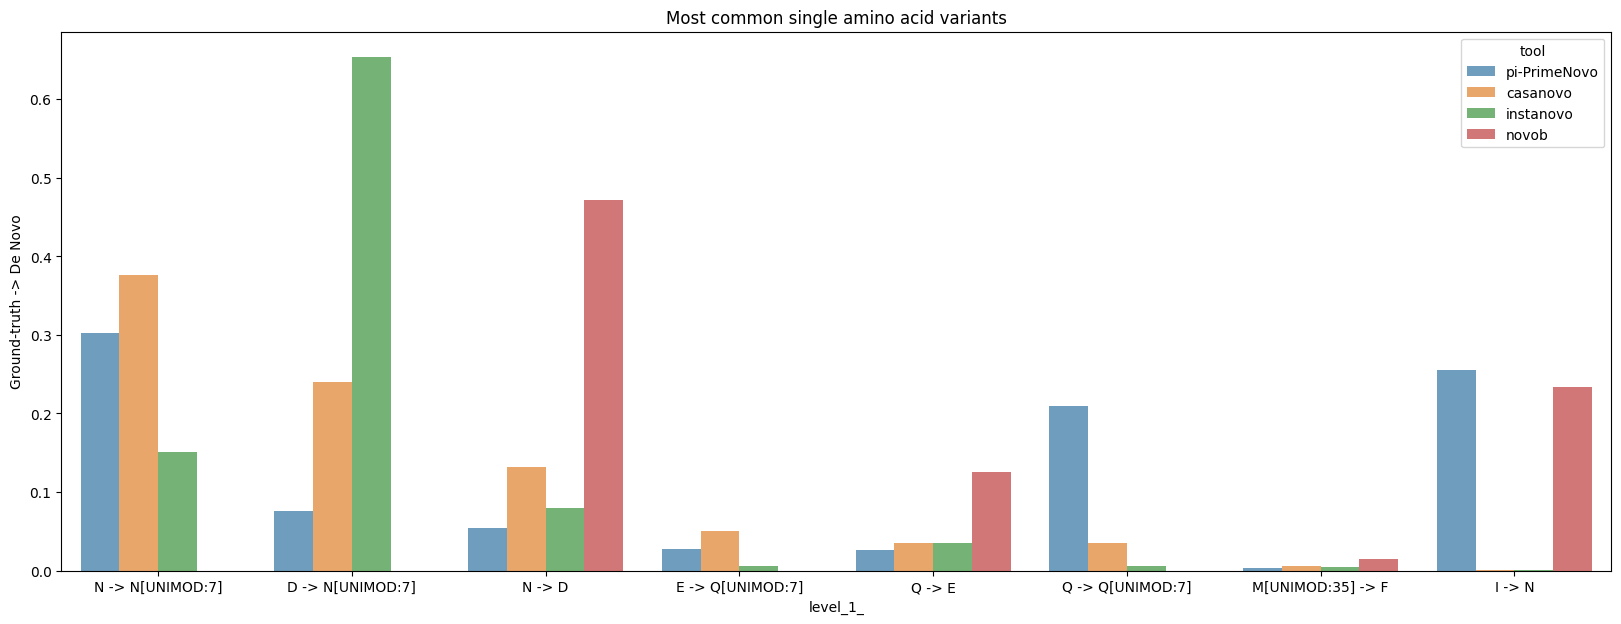

In [62]:
plt.figure(figsize=(20,7))
sns.barplot(
    selection,
    y='percentage',
    x='level_1_',
    hue='tool',
    hue_order=SE_selection,
    alpha=.7
)

plt.title("Most common single amino acid variants")
plt.ylabel('Ground-truth -> De Novo')

Text(0, 0.5, 'Ground-truth -> De Novo')

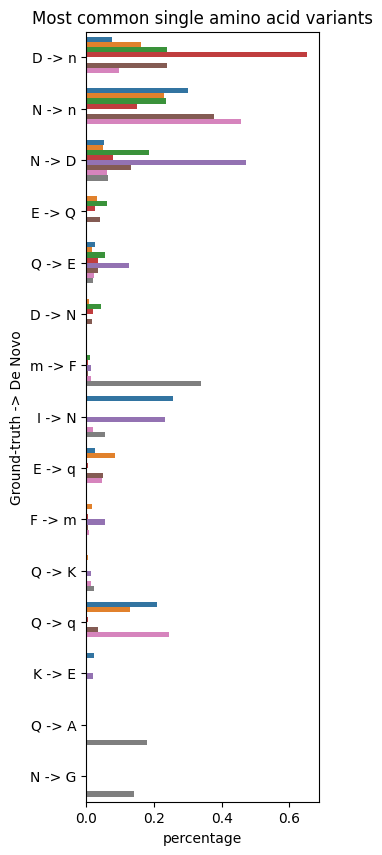

In [18]:
plt.figure(figsize=(3,10))
sns.barplot(
    selection,
    x='percentage',
    y='level_1',
    hue='tool',
    hue_order=denovo_order, legend=False
)


plt.title("Most common single amino acid variants")
plt.ylabel('Ground-truth -> De Novo')

Text(0, 0.5, 'Ground-truth -> De Novo')

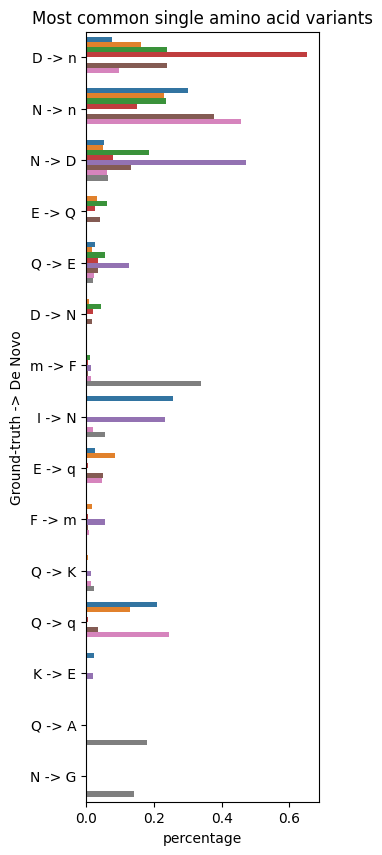

In [517]:
plt.figure(figsize=(3,10))
sns.barplot(
    selection,
    x='percentage',
    y='level_1',
    hue='tool',
    hue_order=denovo_order, legend=False
)


plt.title("Most common single amino acid variants")
plt.ylabel('Ground-truth -> De Novo')

In [587]:
levenshtein_errors.replacements.apply(lambda x: x[0]['s1']=='Q' and x[0]['s2']=='A')

7          False
15         False
16         False
17         False
20         False
           ...  
1390715    False
1390716    False
1390717    False
1390718    False
1390719    False
Name: replacements, Length: 803650, dtype: bool

In [589]:
levenshtein_errors[
    (levenshtein_errors.replacements.apply(lambda x: x[0]['s1']=='A' and x[0]['s2']=='Q')) &
    (levenshtein_errors['levenshtein']==1)
]

,tool,levenshtein,damerau-levenshtein,swaps,peptide_evidence_dn,peptide_evidence_gt,spectrum_id,run,replacements,transpositions,n_locations
306,pepnet,1,1,"[(replace, 11, 11)]",<GN>DFF<QQ>L<QLTA>C[UNIMOD:4]TR/2,GNDFFQQIQLTQC[UNIMOD:4]TR/2,controllerType=0 controllerNumber=1 scan=75313,LFQ_Orbitrap_DDA_Ecoli_01,"[{'s1': 'A', 's2': 'Q', 'indices': [11], 'ambi...",0,1
540,pepnet,1,1,"[(replace, 8, 8)]",<LG>LNC[UNIMOD:4]Q<LA>AVAER/2,IGLNC[UNIMOD:4]QLAQVAER/2,controllerType=0 controllerNumber=1 scan=58267,LFQ_Orbitrap_DDA_Ecoli_01,"[{'s1': 'A', 's2': 'Q', 'indices': [8], 'ambig...",0,1
577,pepnet,1,1,"[(replace, 16, 16)]",<GA>VV<DNTALLTC[UNIMOD:4]LNEG><AK>/2,<GA>VVDNTALLTC[UNIMOD:4]LNE<GQK>/2,controllerType=0 controllerNumber=1 scan=69145,LFQ_Orbitrap_DDA_Ecoli_01,"[{'s1': 'A', 's2': 'Q', 'indices': [16], 'ambi...",0,1
623,pepnet,1,1,"[(replace, 10, 10)]",<VN>PVVP<EVVNA>VC[UNIMOD:4]FK/2,VNPVVPEVVNQVC[UNIMOD:4]FK/2,controllerType=0 controllerNumber=1 scan=74527,LFQ_Orbitrap_DDA_Ecoli_01,"[{'s1': 'A', 's2': 'Q', 'indices': [10], 'ambi...",0,1
1446,pepnet,1,1,"[(replace, 8, 8)]",<LG>LN<C[UNIMOD:4]QLA>AVAER/2,<IG>LNC[UNIMOD:4]QLAQVAER/2,controllerType=0 controllerNumber=1 scan=57833,LFQ_Orbitrap_DDA_Ecoli_01,"[{'s1': 'A', 's2': 'Q', 'indices': [8], 'ambig...",0,1
...,...,...,...,...,...,...,...,...,...,...,...
1274174,pepnet,1,1,"[(replace, 9, 9)]",TC[UNIMOD:4]NVLVALEAQSPDLAQGVHEEK/3,TC[UNIMOD:4]NVLVAIEQQSPDIAQGVHEEK/3,controllerType=0 controllerNumber=1 scan=88832,LFQ_Orbitrap_DDA_Yeast_01,"[{'s1': 'A', 's2': 'Q', 'indices': [9], 'ambig...",0,1
1296208,pepnet,1,1,"[(replace, 10, 10)]",HL<GV>VGEC[UNIMOD:4]NLAYALNPVSK/3,HL<GV>VGEC[UNIMOD:4]NIQYALNPVSK/3,controllerType=0 controllerNumber=1 scan=78261,LFQ_Orbitrap_DDA_Yeast_01,"[{'s1': 'A', 's2': 'Q', 'indices': [10], 'ambi...",0,1
1319072,pepnet,1,1,"[(replace, 3, 3)]",C[UNIMOD:4]V<LA>LR/2,C[UNIMOD:4]VLQIR/2,controllerType=0 controllerNumber=1 scan=39561,LFQ_Orbitrap_DDA_Yeast_01,"[{'s1': 'A', 's2': 'Q', 'indices': [3], 'ambig...",0,1
1319170,pepnet,1,1,"[(replace, 5, 5)]",C[UNIMOD:4]GFTPAYK/2,C[UNIMOD:4]GFTPQYK/2,controllerType=0 controllerNumber=1 scan=33599,LFQ_Orbitrap_DDA_Yeast_01,"[{'s1': 'A', 's2': 'Q', 'indices': [5], 'ambig...",0,1


In [35]:
print(
    Peptidoform('N').theoretical_mass - Peptidoform('D').theoretical_mass
)

-0.9840155826900059


In [576]:
print(
    Peptidoform('N').theoretical_mass - Peptidoform('I').theoretical_mass
)

0.958863464009994


In [578]:
print(
    Peptidoform('K').theoretical_mass - Peptidoform('Q').theoretical_mass
)

0.036385508720002235


In [579]:
print(
    Peptidoform('Q').theoretical_mass - Peptidoform('A').theoretical_mass
)

57.02146372056998


In [580]:
print(
    Peptidoform('N').theoretical_mass - Peptidoform('G').theoretical_mass
)

57.02146372057001


In [582]:
print(
    Peptidoform('C[UNIMOD:4]').theoretical_mass - Peptidoform('C').theoretical_mass
)

57.02146400000001


## 4.2. Most common transpositions

In [ ]:
# Gather the single amino acid variants
saa = levenshtein_df[
    (levenshtein_df['levenshtein'] == 2) &
    (levenshtein_df['damerau-levenshtein'] == 1)
]

# Parse the replacements and count them
pairs = saa['replacements'].apply(lambda x: [f"{i['s2']} -> {i['s1']}" for i in x])
pairs['tool'] = saa['tool']
pairs = pairs.groupby('tool').apply(lambda x: pd.Series(list(chain(*x))).value_counts())
pairs = pairs.reset_index()

pairs['percentage'] = pairs.groupby('tool')['replacements'].transform(lambda x: x / x.sum())

# Make a selection for plotting (only the 15 most common ones)
most_common_aas = pairs.groupby('level_1').replacements.sum().sort_values(ascending=False)[:10].index.tolist()
selection = pairs[pairs['level_1'].isin(most_common_aas)]

selection['level_1_'] = selection['level_1'].apply(
    lambda x: peptidoform_to_lstring(x, mapper_reverse)
)
SE_selection = [
    'pi-PrimeNovo',
    'casanovo',
    'instanovo',
    'novob'
]
selection = selection[selection['tool'].isin(SE_selection)]

<Axes: xlabel='replacements', ylabel='tool'>

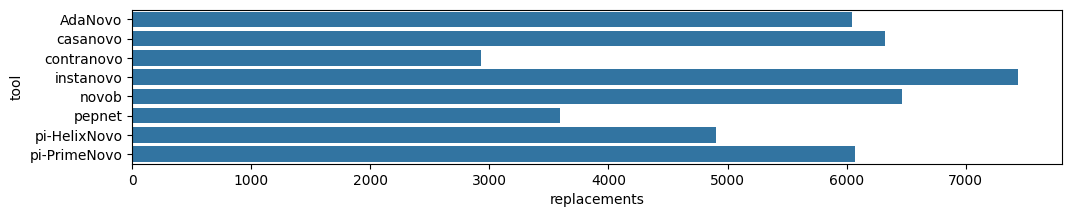

In [520]:
plt.figure(figsize=(12,2))
sns.barplot(pairs.groupby('tool').replacements.sum(), orient='h')

Text(0, 0.5, 'Ground-truth -> De Novo')

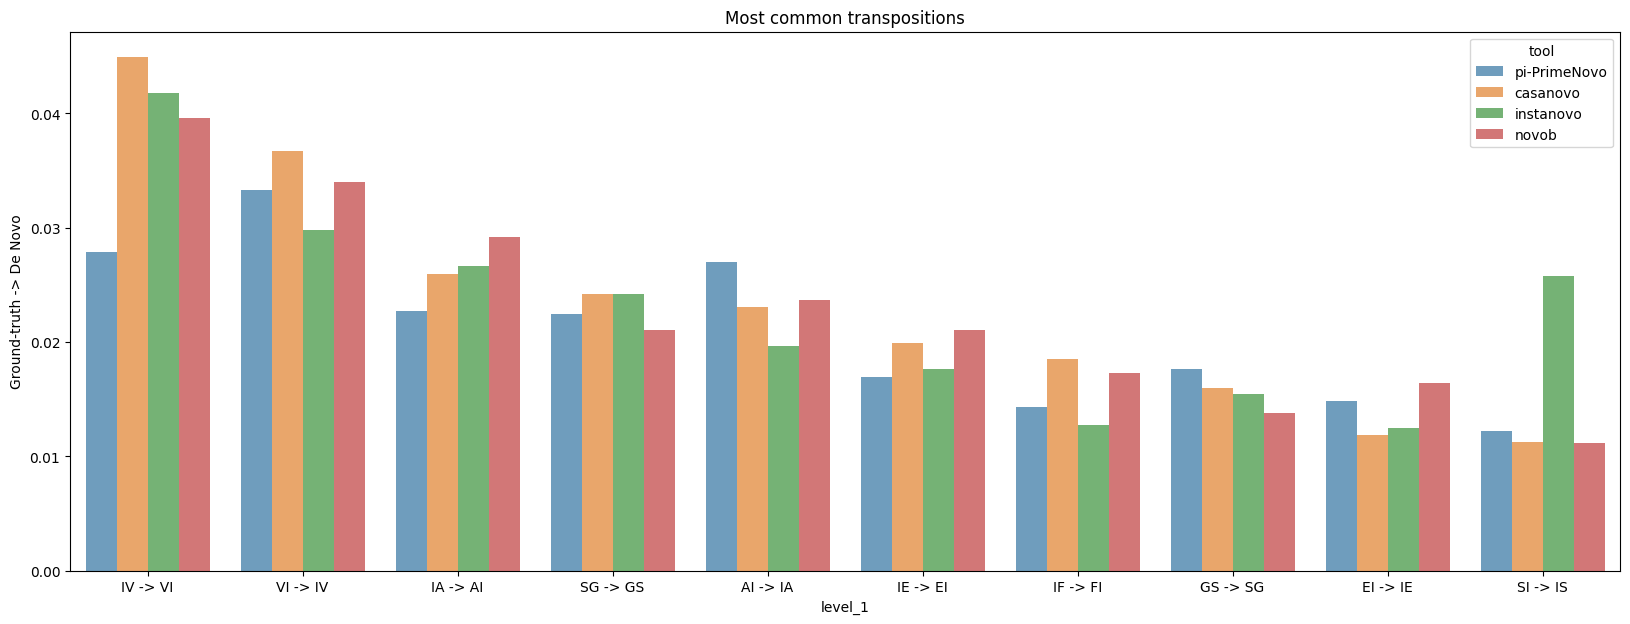

In [60]:
plt.figure(figsize=(20,7))
sns.barplot(
    selection,
    y='percentage',
    x='level_1',
    hue='tool',
    hue_order=SE_selection,
    alpha=.7
)
plt.title("Most common transpositions")
plt.ylabel('Ground-truth -> De Novo')

Text(0, 0.5, 'Ground-truth -> De Novo')

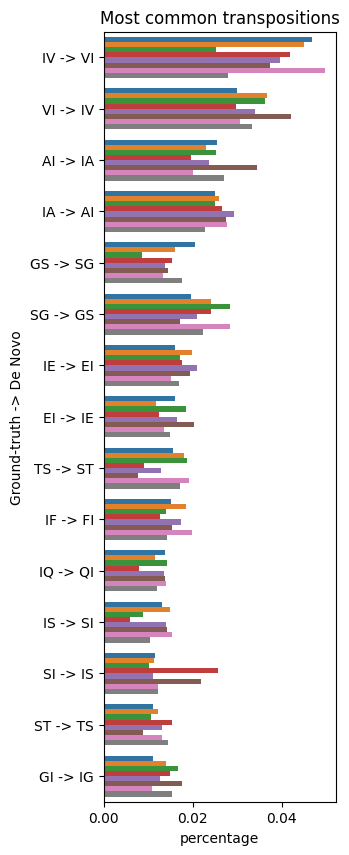

In [591]:
plt.figure(figsize=(3,10))
sns.barplot(
    selection,
    x='percentage',
    y='level_1',
    hue='tool',
    legend=False
)
plt.title("Most common transpositions")
plt.ylabel('Ground-truth -> De Novo')

When making these type of errors, is fragment evidence available ?

In [592]:
saa['ambiguous'] = saa['replacements'].apply(lambda x: x[0]['ambiguous_site'])

Text(0.5, 1.0, 'Proportion no-peak evidence')

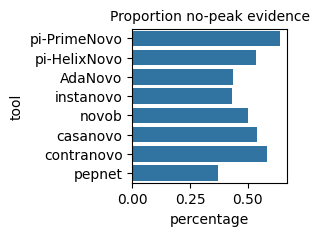

In [606]:
terminus_counts = saa.groupby('tool')['ambiguous'].value_counts()
terminus_counts.name = 'count'
terminus_counts = terminus_counts.reset_index()
terminus_counts['percentage'] = terminus_counts.groupby('tool')['count'].apply(lambda x: x/x.sum())

fig, ax = plt.subplots(1,1, figsize=(2,2))
sns.barplot(
    terminus_counts[terminus_counts['ambiguous']],
    y='tool',
    x='percentage',
    order=denovo_order
)
plt.title('Proportion no-peak evidence', fontsize=10)

In [607]:
terminus_counts

,tool,ambiguous,count,percentage
0,AdaNovo,False,3416,0.565376
1,AdaNovo,True,2626,0.434624
2,casanovo,True,3410,0.539216
3,casanovo,False,2914,0.460784
4,contranovo,True,1711,0.584757
5,contranovo,False,1215,0.415243
6,instanovo,False,4212,0.566129
7,instanovo,True,3228,0.433871
8,novob,True,3247,0.502088
9,novob,False,3220,0.497912


## 4.3 Most common errors within a single site

In [39]:
levenshtein_errors = levenshtein_df.dropna()

In [40]:
levenshtein_errors['n_locations'] = levenshtein_errors.replacements.apply(len)

Overview of number of error sites

In [524]:
location_counts = levenshtein_errors.groupby('tool')['n_locations'].value_counts()
location_counts.name = 'count'
location_counts = location_counts.reset_index()
location_counts.head()
location_counts['percentage'] = location_counts.groupby('tool')['count'].transform(lambda x: x/x.sum())

Text(0.5, 1.0, 'Distribution of errors contained in separate sites')

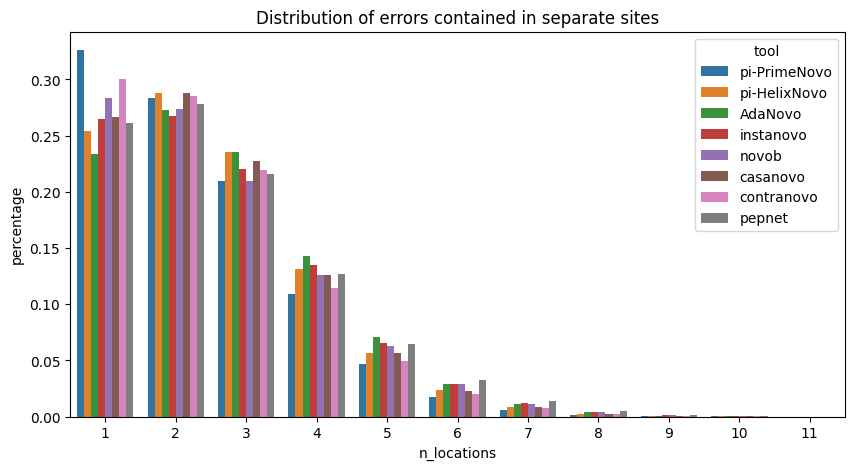

In [525]:
pairs['percentage'] = pairs.groupby('tool')['replacements'].transform(lambda x: x / x.sum())

plt.figure(figsize=(10,5))
sns.barplot(
    location_counts,
    y='percentage',
    x='n_locations',
    hue='tool',
    hue_order=denovo_order
)
plt.title('Distribution of errors contained in separate sites')

Most prominent erros in single sites

In [63]:
# Gather the errors within a single location
saa = levenshtein_errors[
    (levenshtein_errors['n_locations'] == 1) &
    (levenshtein_errors['levenshtein'] < 7) &
    (levenshtein_errors['damerau-levenshtein'] > 1)
]

# Parse the replacements and count them
pairs = saa['replacements'].apply(lambda x: [f"{i['s2']} -> {i['s1']}" for i in x])
pairs['tool'] = saa['tool']
pairs = pairs.groupby('tool').apply(lambda x: pd.Series(list(chain(*x))).value_counts())
pairs = pairs.reset_index()

pairs['percentage'] = pairs.groupby('tool')['replacements'].transform(lambda x: x / x.sum())

# Make a selection for plotting (only the 15 most common ones)
most_common_aas = pairs.groupby('level_1').replacements.sum().sort_values(ascending=False)[:10].index.tolist()
selection = pairs[pairs['level_1'].isin(most_common_aas)]

selection['level_1_'] = selection['level_1'].apply(
    lambda x: peptidoform_to_lstring(x, mapper_reverse)
)
SE_selection = [
    'pi-PrimeNovo',
    'casanovo',
    'instanovo',
    'novob'
]
selection = selection[selection['tool'].isin(SE_selection)]

In [ ]:
plt.figure(figsize=(3,10))
sns.barplot(
    selection,
    y='percentage',
    x='level_1_',
    hue='tool',
    hue_order=denovo_order,
    order=most_common_aas,
    legend=False
)
plt.title("Most common errors in 1 location")
plt.ylabel('Ground-truth -> De Novo')

Text(0, 0.5, 'Ground-truth -> De Novo')

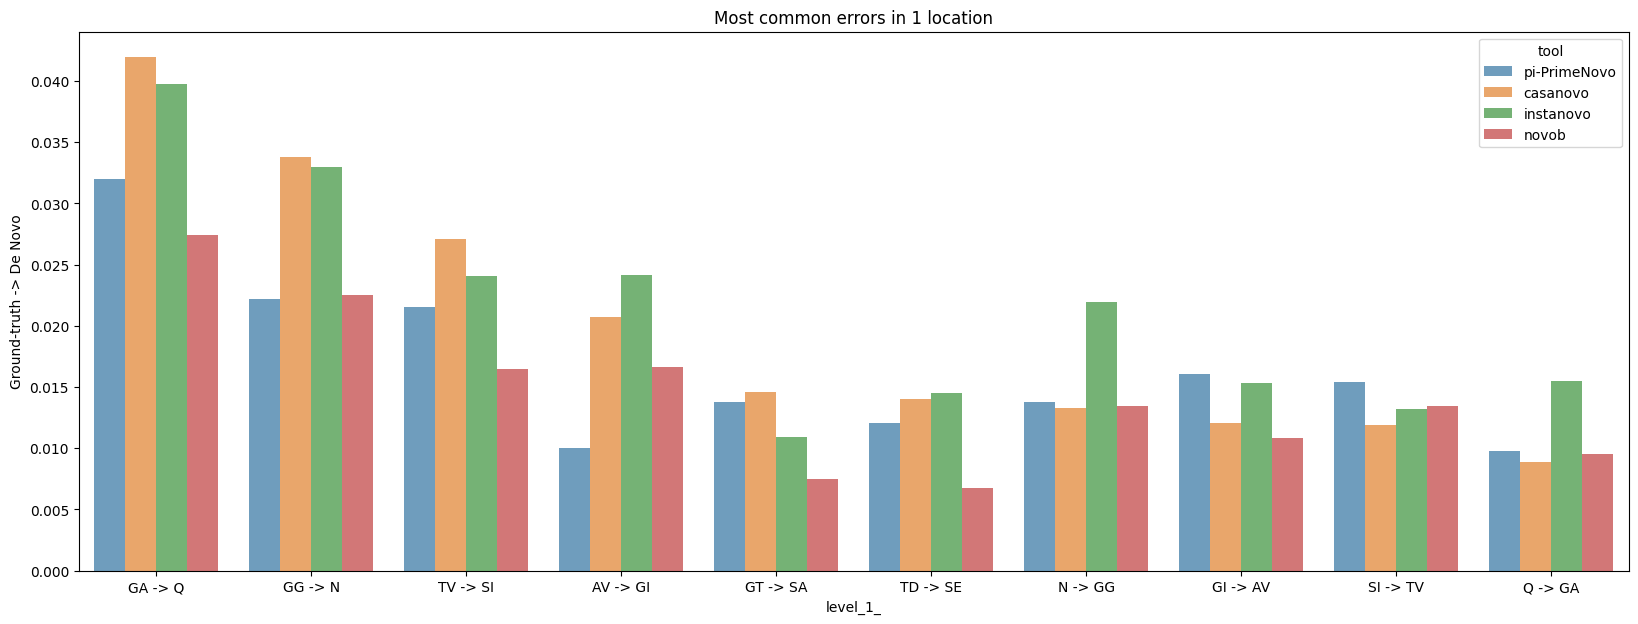

In [66]:
plt.figure(figsize=(20,7))
sns.barplot(
    selection,
    y='percentage',
    x='level_1_',
    hue='tool',
    hue_order=SE_selection,
    alpha=.7
)
plt.title("Most common errors in 1 location")
plt.ylabel('Ground-truth -> De Novo')

## Location of single site errors

In [528]:
saa['n_term'] = saa['replacements'].apply(lambda x: x[0]['n_term'])
saa['c_term'] = saa['replacements'].apply(lambda x: x[0]['c_term'])
saa['ambiguous'] = saa['replacements'].apply(lambda x: x[0]['ambiguous_site'])

In [529]:
def choose_closest(n_term, c_term):
    if n_term < c_term:
        return n_term, 'N'
    else:
        return c_term, "C"

In [530]:
temp = saa.apply(
    lambda x: choose_closest(
        n_term=x['n_term'],
        c_term=x['c_term']
    ), axis=1
)
saa['closest_distance'], saa['terminus'] = temp.apply(lambda x: x[0]), temp.apply(lambda x: x[1])

In [531]:
saa.loc[:, ['tool', 'terminus', 'ambiguous']]

,tool,terminus,ambiguous
20,novob,N,False
31,pi-HelixNovo,N,True
36,novob,N,True
37,pepnet,N,True
84,AdaNovo,N,True
...,...,...,...
1390514,instanovo,C,False
1390534,pi-PrimeNovo,C,True
1390538,novob,C,True
1390629,AdaNovo,N,False


In [532]:
terminus_counts_n = saa[saa['terminus']=='N']
terminus_counts_n = terminus_counts_n.groupby('tool')['ambiguous'].value_counts()
terminus_counts_n.name = 'count'
terminus_counts_n = terminus_counts_n.reset_index()
terminus_counts_n['percentage'] = terminus_counts_n.groupby('tool')['count'].apply(lambda x: x/x.sum())

terminus_counts_c = saa[saa['terminus']=='C']
terminus_counts_c = terminus_counts_c.groupby('tool')['ambiguous'].value_counts()
terminus_counts_c.name = 'count'
terminus_counts_c = terminus_counts_c.reset_index()
terminus_counts_c['percentage'] = terminus_counts_c.groupby('tool')['count'].apply(lambda x: x/x.sum())

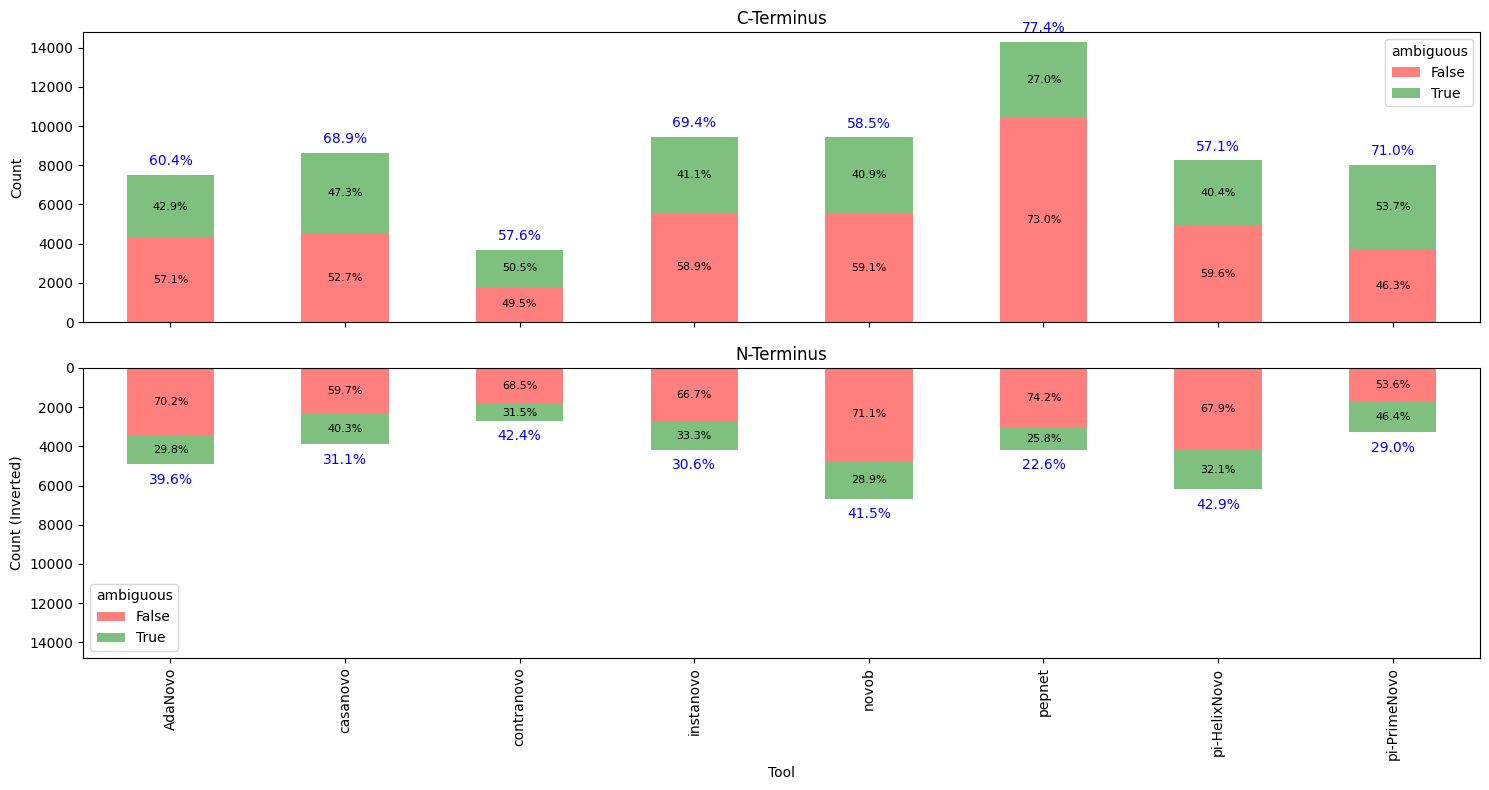

In [533]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Calculate total counts for each tool and terminus
total_c_by_tool = terminus_counts_c.groupby('tool')['count'].sum()
total_n_by_tool = terminus_counts_n.groupby('tool')['count'].sum()
total_counts_by_tool = total_c_by_tool + total_n_by_tool

max_n = terminus_counts_n.groupby('tool')['count'].sum().max() + 500
max_c = terminus_counts_c.groupby('tool')['count'].sum().max() + 500

# Plot for terminus_counts_c
pivot_c = terminus_counts_c.pivot_table(values='count', index='tool', columns='ambiguous')
pivot_c.plot(kind='bar', stacked=True, ax=ax[0], color=['red', 'green'], alpha=0.5)

ax[0].set_title("C-Terminus")
ax[0].set_ylabel("Count")

# Annotate bars with percentages for terminus_counts_c
for container in ax[0].containers:
    totals = pivot_c.sum(axis=1)
    for bar, total, tool in zip(container, totals, pivot_c.index):
        if bar.get_height() > 0:
            percentage = f"{bar.get_height() / total * 100:.1f}%"
            ax[0].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                percentage,
                ha="center",
                va="center",
                fontsize=8,
                color="black",
            )

# Add tool-specific percentage for C-Terminus on top of the bars
for i, tool in enumerate(pivot_c.index):
    tool_percentage_c = total_c_by_tool[tool] / total_counts_by_tool[tool] * 100
    ax[0].text(
        i,  # X-coordinate (tool index)
        total_c_by_tool[tool]+500,  # Y-coordinate (above the top of the bars)
        f"{tool_percentage_c:.1f}%",
        ha="center",
        fontsize=10,
        color="blue",
    )

# Plot for terminus_counts_n (inverted)
pivot_n = terminus_counts_n.pivot_table(values='count', index='tool', columns='ambiguous')
pivot_n.plot(kind='bar', stacked=True, ax=ax[1], color=['red', 'green'], alpha=0.5)

ax[1].set_title("N-Terminus")
ax[1].invert_yaxis()  # Invert the y-axis for the second plot
ax[1].set_ylabel("Count (Inverted)")

# Annotate bars with percentages for terminus_counts_n
for container in ax[1].containers:
    totals = pivot_n.sum(axis=1)
    for bar, total, tool in zip(container, totals, pivot_n.index):
        if bar.get_height() > 0:
            percentage = f"{bar.get_height() / total * 100:.1f}%"
            ax[1].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                percentage,
                ha="center",
                va="center",
                fontsize=8,
                color="black",
            )

# Add tool-specific percentage for N-Terminus on top of the bars
for i, tool in enumerate(pivot_n.index):
    tool_percentage_n = total_n_by_tool[tool] / total_counts_by_tool[tool] * 100
    ax[1].text(
        i,  # X-coordinate (tool index)
        total_n_by_tool[tool]+1000,  # Y-coordinate (above the top of the bars)
        f"{tool_percentage_n:.1f}%",
        ha="center",
        fontsize=10,
        color="blue",
    )

# Customize shared x-axis
ax[1].set_xlabel("Tool")

ax[0].set_ylim(0, max(max_n, max_c))
ax[1].set_ylim(0, max(max_n, max_c))
ax[1].invert_yaxis()  # Invert the y-axis for the second plot

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Error in no-peak evidence zone (C-terminus)')

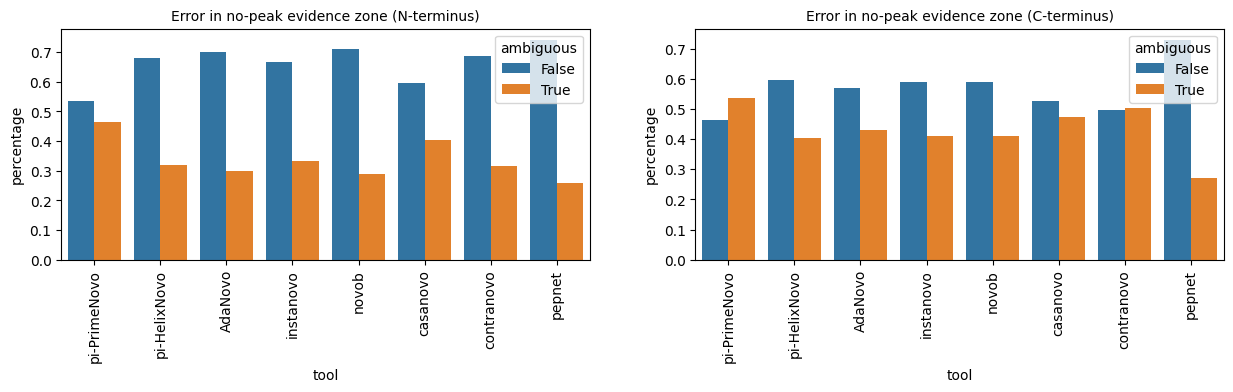

In [535]:
terminus_counts = saa[saa['terminus']=='N'].groupby('tool')['ambiguous'].value_counts()
terminus_counts.name = 'count'
terminus_counts = terminus_counts.reset_index()
terminus_counts['percentage'] = terminus_counts.groupby('tool')['count'].apply(lambda x: x/x.sum())

fig, ax = plt.subplots(1,2, figsize=(15,3))
sns.barplot(
    terminus_counts,
    x='tool',
    y='percentage',
    hue='ambiguous',
    order=denovo_order,
    ax=ax[0]
)

terminus_counts = saa[saa['terminus']=='C'].groupby('tool')['ambiguous'].value_counts()
terminus_counts.name = 'count'
terminus_counts = terminus_counts.reset_index()
terminus_counts['percentage'] = terminus_counts.groupby('tool')['count'].apply(lambda x: x/x.sum())

sns.barplot(
    terminus_counts,
    x='tool',
    y='percentage',
    hue='ambiguous',
    order=denovo_order,
    ax=ax[1]
)

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

ax[0].set_title('Error in no-peak evidence zone (N-terminus)', fontsize=10)
ax[1].set_title('Error in no-peak evidence zone (C-terminus)', fontsize=10)

In [551]:
term_distances_n = saa[saa['terminus']=='N'].groupby(['tool', 'closest_distance']).count()['spectrum_id'].reset_index()
term_distances_n['percentage'] = term_distances_n.groupby('tool').spectrum_id.apply(lambda x: x/x.sum())

term_distances_c = saa[saa['terminus']=='C'].groupby(['tool', 'closest_distance']).count()['spectrum_id'].reset_index()
term_distances_c['percentage'] = term_distances_c.groupby('tool').spectrum_id.apply(lambda x: x/x.sum())

In [552]:
term_distances_c

,tool,closest_distance,spectrum_id,percentage
0,AdaNovo,-1,153,0.020381
1,AdaNovo,0,1375,0.183162
2,AdaNovo,1,2996,0.399094
3,AdaNovo,2,1155,0.153856
4,AdaNovo,3,844,0.112428
...,...,...,...,...
110,pi-PrimeNovo,9,34,0.004238
111,pi-PrimeNovo,10,11,0.001371
112,pi-PrimeNovo,11,4,0.000499
113,pi-PrimeNovo,12,5,0.000623


<Axes: title={'center': 'Distance error site to C-terminus'}, xlabel='closest_distance', ylabel='percentage'>

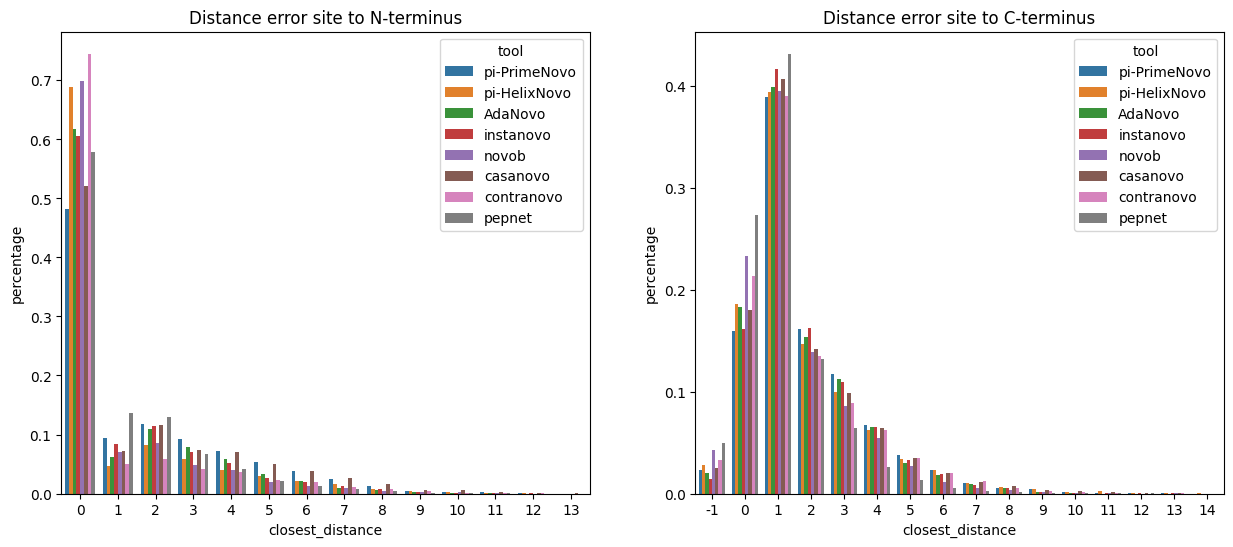

In [555]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].set_title('Distance error site to N-terminus')
ax[1].set_title('Distance error site to C-terminus')
sns.barplot(
    term_distances_n,
    x='closest_distance',
    y='percentage',
    hue='tool',
    ax=ax[0],
    hue_order=denovo_order
)
sns.barplot(
    term_distances_c,
    x='closest_distance',
    y='percentage',
    hue='tool',
    ax=ax[1],
    hue_order=denovo_order
)

<Axes: title={'center': 'Distance error site to C-terminus'}, xlabel='closest_distance', ylabel='count'>

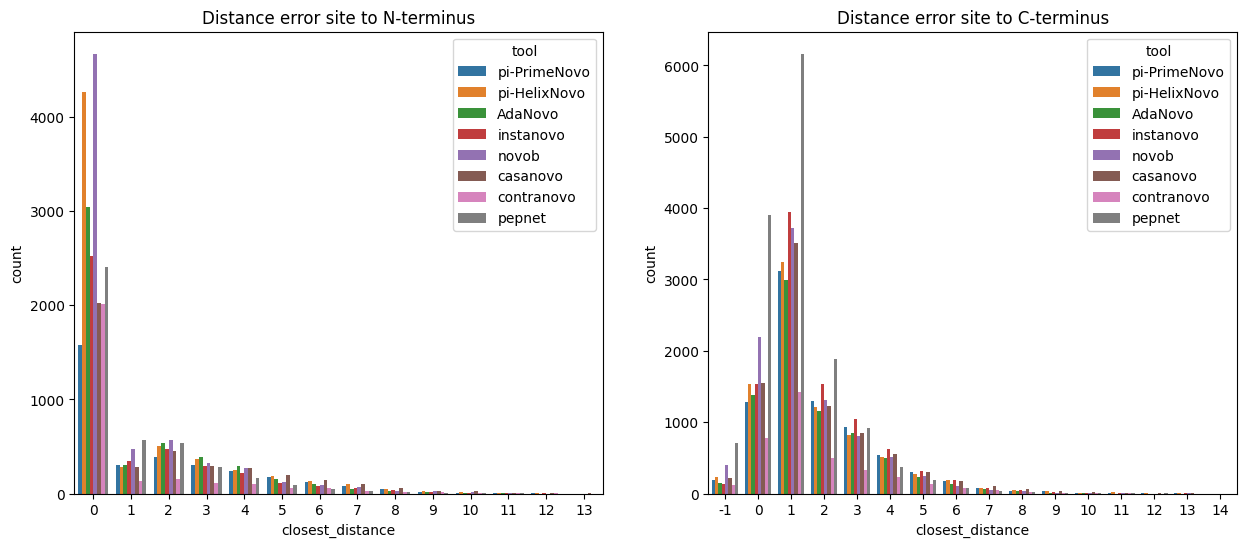

In [536]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].set_title('Distance error site to N-terminus')
ax[1].set_title('Distance error site to C-terminus')
sns.countplot(
    saa[saa['terminus']=='N'],
    x='closest_distance',
    hue='tool',
    ax=ax[0],
    hue_order=denovo_order
)
sns.countplot(
    saa[saa['terminus']=='C'],
    x='closest_distance',
    hue='tool',
    ax=ax[1],
    hue_order=denovo_order
)